<a href="https://colab.research.google.com/github/abhilashhn1993/Sentiment_Analysis_of_Tweets/blob/master/TFIDF_and_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!pip install spacy
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.2MB/s 
     |████████████████████████████████| 552kB 21.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=53fdf668c58b045b4deea42760d433246f1ea2753ed0365d6ff4c81b3dd22dc5
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=b39582f5a038beba7bd8e3aee62b4fbfe6c069b3828c643a9ac87b98c0335ffe
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [0]:
#remove been, being, haven't, don't, couldn't, didn't
stop_words.remove("i")
stop_words.remove("me")
stop_words.remove("my")
stop_words.remove("don't")
stop_words.remove("been")
stop_words.remove("being")
stop_words.remove("haven't")
stop_words.remove("couldn't")
stop_words.remove("didn't")

In [0]:
#Adding Extra Stopwords to be removed from the dataset
stop_words.extend(['http', 'https', 'twitter', 'www', 'instagram', 'zsgdbw', 'tmblr', 'co', 'twitch','facebook', 'snapchat'])

In [8]:
len(stop_words)

181

In [0]:
stop_words.extend(['make','really','see','go','would','even','get','com','be','year','still','do','know','actually','much', 'let','s','have','name','photo'])
stop_words.extend(['back','today','day','last','thing','kit','stream','amp'])
stop_words.extend(['trinawolfy','trinawolfy','riyenrootsmusic','straw'])

In [12]:
len(stop_words)

213

In [14]:
from google.colab import files
uploaded = files.upload()

Saving All_PTSD_tweets_Flagged.csv to All_PTSD_tweets_Flagged.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['All_PTSD_tweets_Flagged.csv']))

In [16]:
df.Ptsd.value_counts()

1    113901
0     72629
Name: Ptsd, dtype: int64

In [0]:
#Concatenate by username and Ptsd flag variable
df = df[['Username', 'Tweets','Ptsd']]
df1 = df.groupby(['Username','Ptsd'])['Tweets'].agg(' '.join).reset_index(name='Tweets')

In [21]:
df1.iloc[0].Tweets

'Sucks ass!!! Back at you sweet lady! You too! @KarenUnrue need video lift! Please give if you can. So glad you did that! Hugs You got this Duck! Thank you Donna. I think you are just the best!!  Yes indeed! Awesome We have far too many balls to juggle - folks dementia slide - making new safe home - feel unsafe/unfamiliar - friendship losses - butt pain - hip months pain - high living costs - lack full med coverage - building remodelling daily noise - flashbacks I will race you! Distraction has helped me. Grounding in Now. Breathe lots. I can relate. Tangled branches Buried deep Encased in ice Cold and still Frozen roots To life In dormancy ~A.R.* The is only one you With flaws and all As meant to be Unique and true To self Be your best Fragments of self http://idisassociate.blogspot.com/2016/08/fragments-of-self.html Grounding in the Now http://idisassociate.blogspot.com/2016/12/grounding-in-now.html Help Hotlines http://idisassociate.blogspot.com/2017/07/help-hotlines_5.html The \'No

In [0]:
# Convert to list
df1.Tweets = df1.Tweets.values.tolist()
# Remove Emails
df1.Tweets = [re.sub('\S*@\S*\s?', '', sent) for sent in df1.Tweets]
# Remove new line characters
df1.Tweets = [re.sub('\s+', ' ', sent) for sent in df1.Tweets]
# Remove distracting single quotes
df1.Tweets = [re.sub("\'", "", sent) for sent in df1.Tweets]
pprint(df1.Tweets[:1])

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [28]:
df1.Tweets = list(sent_to_words(df1.Tweets))
print(df1.Tweets[:1])

0    [sucks, ass, back, at, you, sweet, lady, you, ...
Name: Tweets, dtype: object


In [29]:
len(df1.Tweets[0])

15887

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [0]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [32]:
len(df1.Tweets[13])

4948

In [0]:
# Remove Stop Words
df1.Tweets = remove_stopwords(df1.Tweets)

In [34]:
len(df1.Tweets[13])

2623

In [0]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
# Do lemmatization keeping only noun, adj, vb, adv
df1.Tweets = lemmatization(df1.Tweets, allowed_postags=['NOUN','ADJ','VERB','ADV'])
len(df1['Tweets'])

In [0]:
df1.Tweets = remove_stopwords(df1.Tweets)

In [0]:
#Write the Lammetized data into a CSV file
df1.to_csv('Final_lammetized.csv')

**Creating strlist for tfidf Vectorizer**

In [0]:
#Creating a strlist for tf-idf vectorizer
tweetsList =[]
def listToString(s):
    str1 = " "    
    return (str1.join(s))

In [99]:
for strlist in df1.Tweets:
    strg = listToString(strlist)
    tweetsList.append(strg)
print(tweetsList[0:50])

['suck ass sweet lady need video lift give glad hug thank think best indeed awesome far many ball juggle folk dementia slide new safe home feel unsafe unfamiliar friendship loss butt pain hip month pain high living cost lack full med coverage building remodelle daily noise flashback race distraction help ground breathe lot relate tangle branch bury deep encased ice cold frozen root life dormancy flaw mean unique true self good fragment self idisassociate blogspot fragment self ground blogspot ground help idisassociate blogspot help word idisassociate blogspot word poetry idisassociate poetry idisassociate blogspot trauma grieving html work idisassociate blogspot new finish html keep talk ok wookie gym follow help follower need gas mask right lava love never send strength well finally gain ground work part morning folk love hope safe friend understand island sleepy side sore body chance box nice wonderful thought wish wonderful new lovely dear friend word take heart love need life missi

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vec = TfidfVectorizer(max_features=10000)

In [0]:
#Putting the tfidf matrix into a pandas dataframe
tfidf_df = pd.DataFrame(data=vec.fit_transform(tweetsList).todense(), columns=vec.get_feature_names())

In [0]:
#Concatenating the original dataset and the tfidf vector matrix for classifier
df2=df1.iloc[:,[0,1]]
df_res = pd.concat([tfidf_df, df2], axis=1, sort=False)

In [111]:
df_res.shape

(112, 10002)

In [127]:
df_res[:-1]

,ab,abandon,abbotsford,abcmodernfam,abeg,abide,ability,able,ableism,ableist,abnormal,abolish,abolition,abomination,abort,abortion,abroad,absence,absent,absolute,absolutely,absorb,abstain,abstract,absurd,abt,abundance,abuse,abuser,abusive,academia,academic,accent,accept,acceptable,acceptance,access,accessibility,accessible,accessory,...,yet,yfrog,yield,yike,yk,yo,yoda,yoga,yogurt,youneverknow,young,younger,youngster,yous,youth,youtu,youtube,youtuber,youuuu,youuuuuu,yr,yrs,yt,yuck,yummy,yup,yyc,za,zeecineaward,zero,zillion,zip,zombie,zone,zoo,zoolight,zoom,લમપ,Username,Ptsd
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001563,0.006809,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.009239,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.001529,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.002010,0.0,0.000000,0.0,0.000000,0.0,...,0.002742,0.0,0.0,0.000000,0.0,0.0,0.0,0.001953,0.0,0.0,0.003961,0.000000,0.0,0.00966,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.001694,0.0,0.0,0.0,0.0,AFR365,1
1,0.0,0.007534,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.011474,0.0,0.000000,0.0,0.000000,0.0,0.009103,0.000000,0.008308,0.014847,0.0,0.000000,0.0,0.000000,0.0,...,0.006753,0.0,0.0,0.007648,0.0,0.0,0.0,0.000000,0.0,0.0,0.003658,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.009947,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,AlishaaHasan,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.018362,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.015831,0.0,...,0.017253,0.0,0.0,0.000000,0.0,0.0,0.0,0.245745,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,AmyRollitt,1
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.004616,0.011492,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.003259,0.000000,0.0,0.0,0.000000,0.006064,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.001661,0.000000,0.0,0.004419,0.0,0.000000,0.0,...,0.033744,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.013162,0.004587,0.0,0.00000,0.0,0.0,0.009389,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.003977,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.045035,0.0,0.0,0.0,0.0,BenBarbossa,1
4,0.0,0.003366,0.0,0.0,0.0,0.0,0.007738,0.004816,0.0,0.0,0.00553,0.009357,0.0,0.0,0.000000,0.007284,0.004243,0.0,0.0,0.018740,0.060989,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.015139,0.0,0.003417,0.0,0.004067,0.003135,0.001856,0.006633,0.0,0.022222,0.0,0.000000,0.0,...,0.006034,0.0,0.0,0.000000,0.0,0.0,0.0,0.003223,0.0,0.0,0.011440,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,BethLynch2020,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.000000,0.0,0.0,0.0,0.0,0.012645,0.007870,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.016611,0.000000,0.000000,0.0,0.020356,0.000000,0.0,0.012370,0.0,0.000000,0.0,0.000000,0.000000,0.009098,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.022185,0.0,0.0,0.016751,0.0,0.0,0.0,0.000000,0.0,0.0,0.032049,0.000000,0.0,0.00000,0.0,0.0,0.010287,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,swampgg,1
107,0.0,0.004056,0.0,0.0,0.0,0.0,0.003

In [124]:
df_res.iloc[:,10000]

0             AFR365
1       AlishaaHasan
2         AmyRollitt
3        BenBarbossa
4      BethLynch2020
           ...      
107    sweetderacine
108    twilightfairy
109        upsetvet1
110        vkhillier
111            xtina
Name: Username, Length: 112, dtype: object

**Train and Test Data split based on 70-30 ratio**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_res.iloc[:,0:9999],df_res['Ptsd'], test_size=0.3, random_state=1)

In [113]:
X_train.shape

(78, 9999)

In [114]:
X_test.shape

(34, 9999)

In [115]:
y_test.shape

(34,)

In [116]:
y_train.shape

(78,)

**LOGISTIC REGRESSION MODEL WITH K-FOLD CROSS VALIDATION**

In [0]:
from sklearn.linear_model.logistic import LogisticRegression
logReg = LogisticRegression()

In [63]:
logReg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score

**Model Validation on the Test data**

In [0]:
scores = cross_val_score(logReg, X_test, y_test, cv=5)

In [76]:
print("Accuracy is", scores.mean()*100, "percent")

Accuracy is 70.47619047619047 percent


In [0]:
predictions = logReg.predict(X_test)

In [0]:
pred_score = logReg.score(X_test, y_test)
print(pred_score*100)

**CONFUSION MATRIX**

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [91]:
conf = metrics.confusion_matrix(y_test, predictions)
print(conf)

[[ 4  6]
 [ 0 24]]


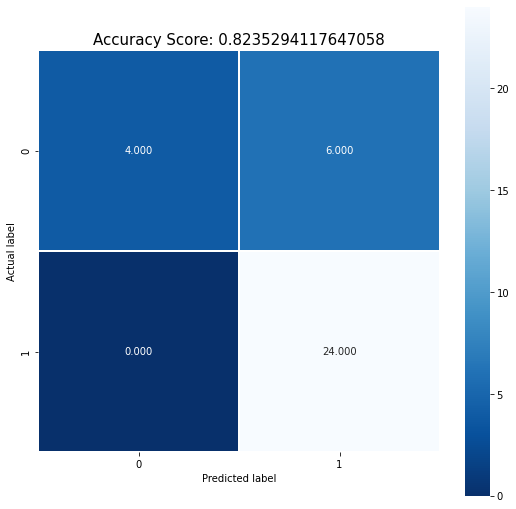

In [89]:
plt.figure(figsize=(9,9))
sns.heatmap(conf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);